In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"
import warnings
warnings.filterwarnings("ignore")

In [2]:
import requests
import io

url = 'https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv'
res = requests.get(url).content
df = pd.read_csv(io.StringIO(res.decode('utf-8')), header=0, index_col=0, parse_dates=True)

target = "Tokyo"
df["log_Tokyo"] = np.log1p(df[target]).diff()
# 前日
df["a_day_ago_Tokyo"] = df["log_Tokyo"].shift(1)

In [3]:
df.head()

,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa,log_Tokyo,a_day_ago_Tokyo
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2020-01-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,NaN
2020-01-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
2020-01-19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
2020-01-20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0


In [4]:
df.tail()

,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa,log_Tokyo,a_day_ago_Tokyo
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-10,42045,2400,379,308,640,372,168,505,573,475,...,2251,357,505,795,506,416,961,2265,0.390749,-0.447508
2022-05-11,45862,3259,415,314,623,262,261,595,595,550,...,2401,369,569,732,435,790,730,2702,0.067944,0.390749
2022-05-12,41657,3176,444,276,475,223,205,560,649,408,...,2424,364,481,649,408,536,767,2330,-0.122174,0.067944
2022-05-13,39582,3034,373,292,494,233,255,498,645,391,...,2198,309,394,582,353,492,633,2242,-0.025701,-0.122174
2022-05-14,39339,2771,353,261,512,202,284,529,641,397,...,2114,308,415,596,358,550,640,2464,-0.078422,-0.025701


In [5]:
df['Tokyo'].tail()

Date
2022-05-10    4451
2022-05-11    4764
2022-05-12    4216
2022-05-13    4109
2022-05-14    3799
Name: Tokyo, dtype: int64

In [6]:
# 目的変数
target_column = "log_Tokyo"
# 説明変数 
ex_columns = [
    "a_day_ago_Tokyo",
]

# 学習期間の設定
train_start = df.index.get_loc("2022-01-01")
train_end = df.index.get_loc("2022-04-01")
test_start = df.index.get_loc("2022-04-01")
test_end = len(df) -1 # 最後まで

w = 10 # 窓幅
N = 1 # N期先予測
dif = 1 # 何次差分を取るか

# 学習データ
df_tr = df.iloc[train_start : train_end]
Ytr = df_tr[target_column].to_numpy().ravel()
Xtr = df_tr[target_column].to_numpy()
Ytr_org = df.iloc[train_start : train_end]["Tokyo"]
Ytr_org = Ytr_org[N+w-1-dif : -1]
print("Training data", len(Xtr))


# テストデータ
df_ts = df.iloc[test_start :]
Yts = df_ts[target_column].to_numpy().ravel()
Xts = df_ts[target_column].to_numpy()
Yts_org = df.iloc[test_start : ]["Tokyo"]
Yts_org = Yts_org[N+w-1-dif : -1]
print("Test data", len(Xts))

Training data 90
Test data 44


In [7]:
from sklearn.preprocessing import StandardScaler

# 標準化
scalerX = StandardScaler()
scalerY = StandardScaler()
Xtr_norm = scalerX.fit_transform(Xtr.reshape(-1, 1))
Ytr_norm = scalerY.fit_transform(Ytr.reshape(-1, 1))
Xts_norm = scalerX.transform(Xts.reshape(-1, 1))
Yts_norm = scalerY.transform(Yts.reshape(-1, 1))

In [8]:
# 学習データ
Xtr_trs = Xtr_norm
for i in range(w-1):
    Xtr_trs = np.hstack([Xtr_trs, np.roll(Xtr_norm, i+1)])
Xtr_trs = Xtr_trs[N+w-1-dif:-1] # 学習データの説明変数の前からN+w-1行は削れる
#Ytr_trs = np.roll(Ytr_norm, -N) # 予測先のNだけずらす
Ytr_trs = Ytr_norm[N+w-dif:]
print(Xtr_trs.shape, Ytr_trs.shape, Ytr_org.shape)


# テストデータ
Xts_trs = Xts_norm
for i in range(w-1):
    Xts_trs = np.hstack([Xts_trs, np.roll(Xts_norm, i+1)])
Xts_trs = Xts_trs[N+w-1-dif:-1]
#Yts_trs = np.roll(Yts_norm, -N)
Yts_trs = Yts_norm[N+w-dif:]
print(Xts_trs.shape, Yts_trs.shape, Yts_org.shape)

(80, 10) (80, 1) (80,)
(34, 10) (34, 1) (34,)


In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

a = 100

model = Ridge(alpha=a)
model.fit(Xtr_trs, Ytr_trs)
Ytr_pred = model.predict(Xtr_trs)
# 標準化戻す
Ytr_pred_inv = scalerY.inverse_transform(Ytr_pred).reshape(-1, ) # 予測
Ytr_pred_inv_log_inv = np.expm1(Ytr_pred_inv + np.log1p(Ytr_org)) # expm1(予測値+log1p(前日の値))が予測値になる
print(f'学習MAE：{mean_absolute_error(Ytr_pred_inv_log_inv, Ytr_org)}')

Yts_pred = model.predict(Xts_trs)
# 標準化戻す
Yts_pred_inv = scalerY.inverse_transform(Yts_pred).reshape(-1, ) # 予測
Yts_pred_inv_log_inv = np.expm1(Yts_pred_inv + np.log1p(Yts_org)) # expm1(予測値+log1p(前日の値))が予測値になる
print(f'テストMAE：{mean_absolute_error(Yts_pred_inv_log_inv, Yts_org)}')

学習MAE：1033.2624522717842
テストMAE：479.63163788932223


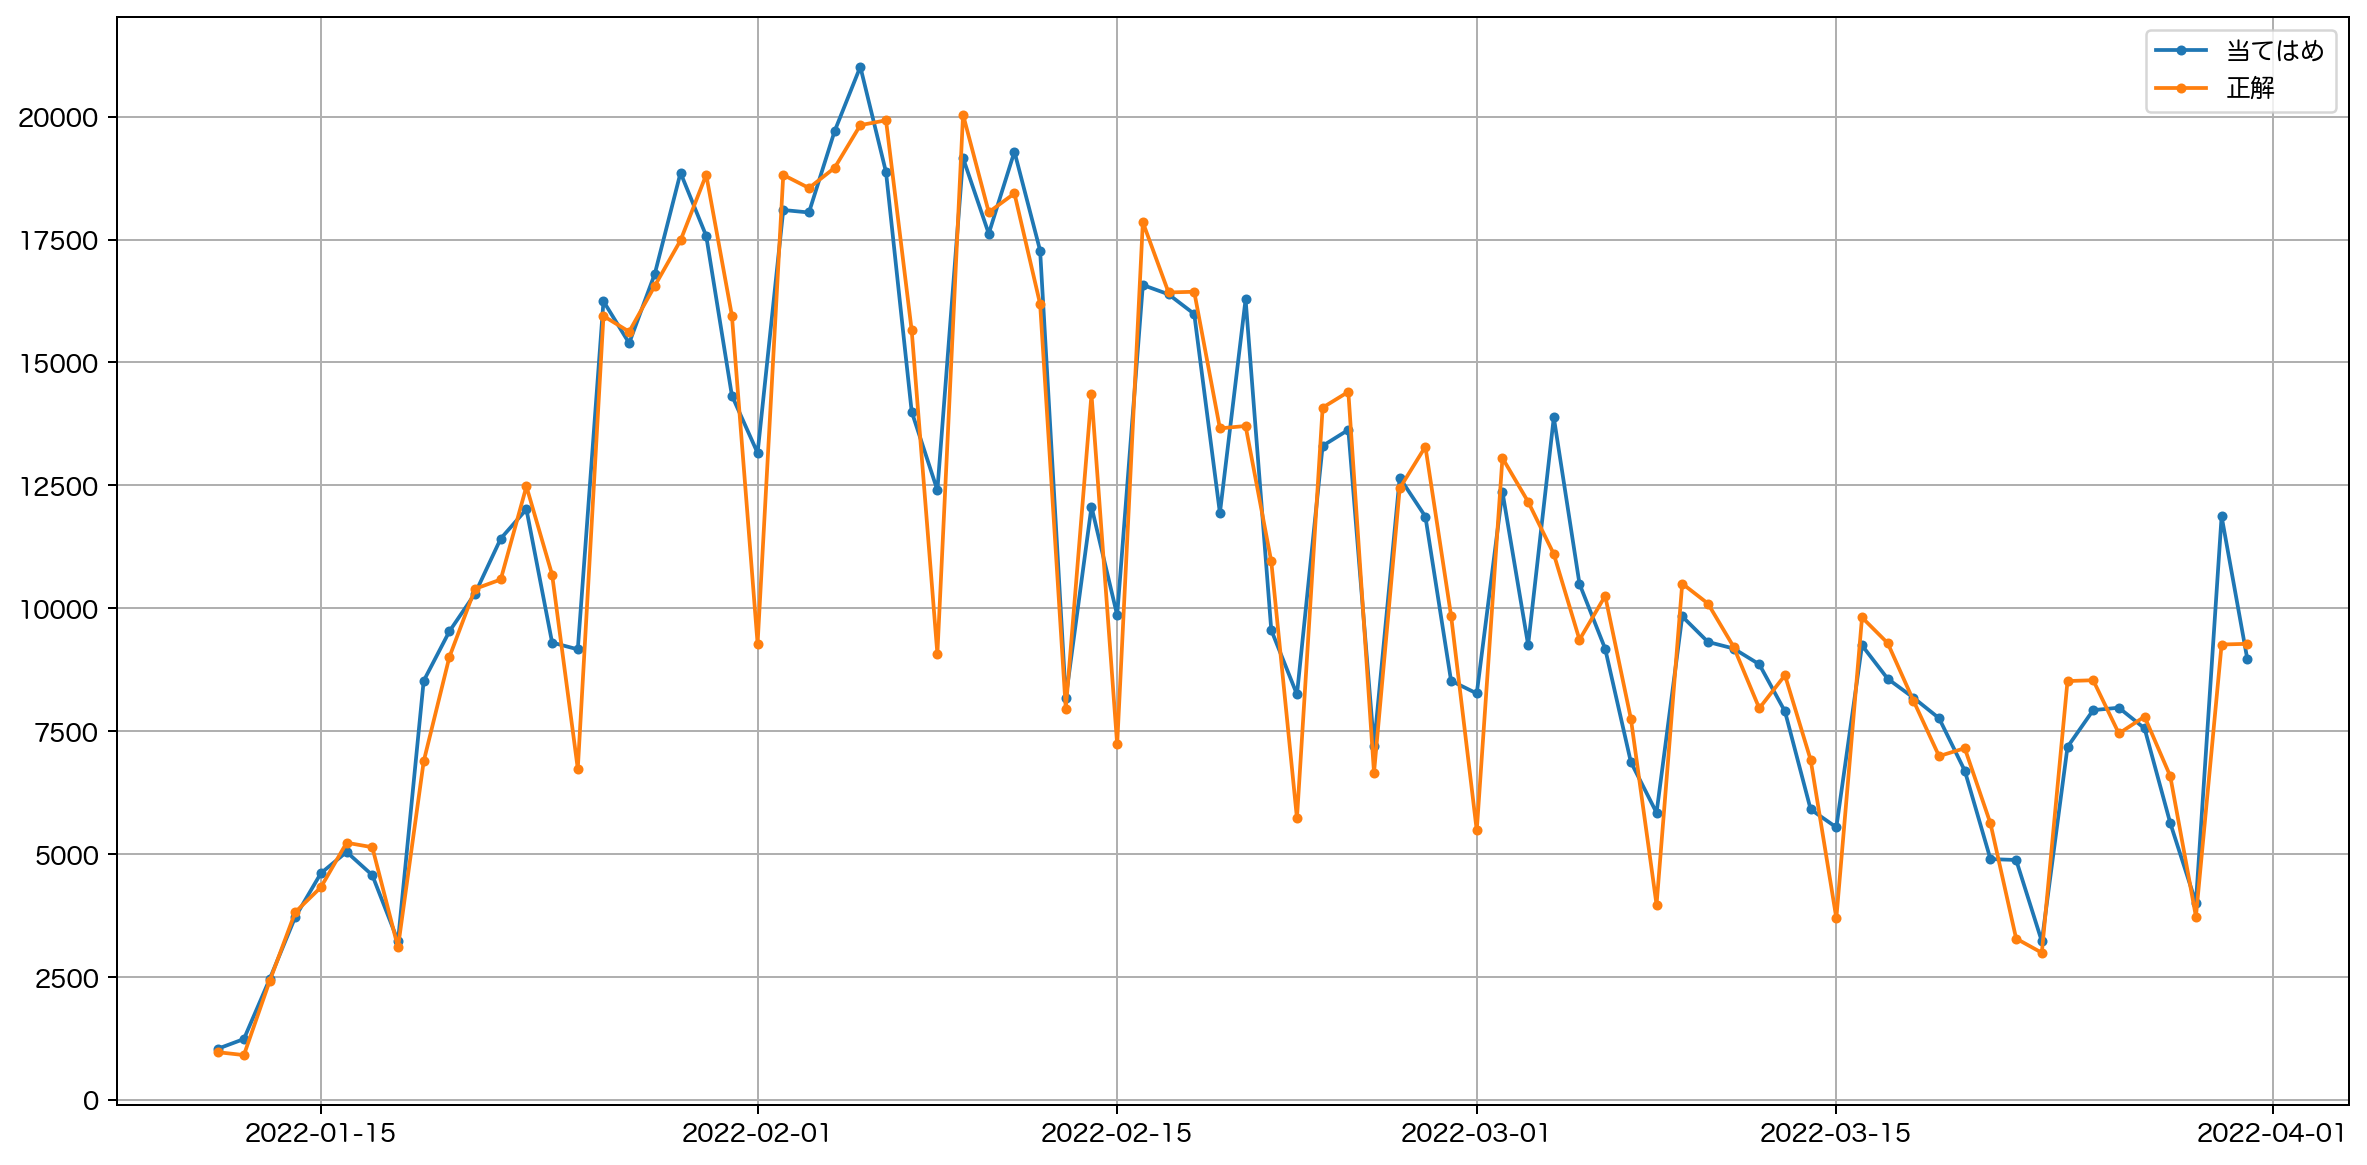

In [10]:
# 学習
fig = plt.figure(figsize=(16, 8), dpi=180)
ax = fig.add_subplot(111)
x = df.index[train_start+(N+w-1):train_end]
ax.plot(x, Ytr_pred_inv_log_inv, label="当てはめ", marker=".")
ax.plot(x, Ytr_org, label="正解", marker=".")
ax.legend()
plt.grid(True)
plt.show()

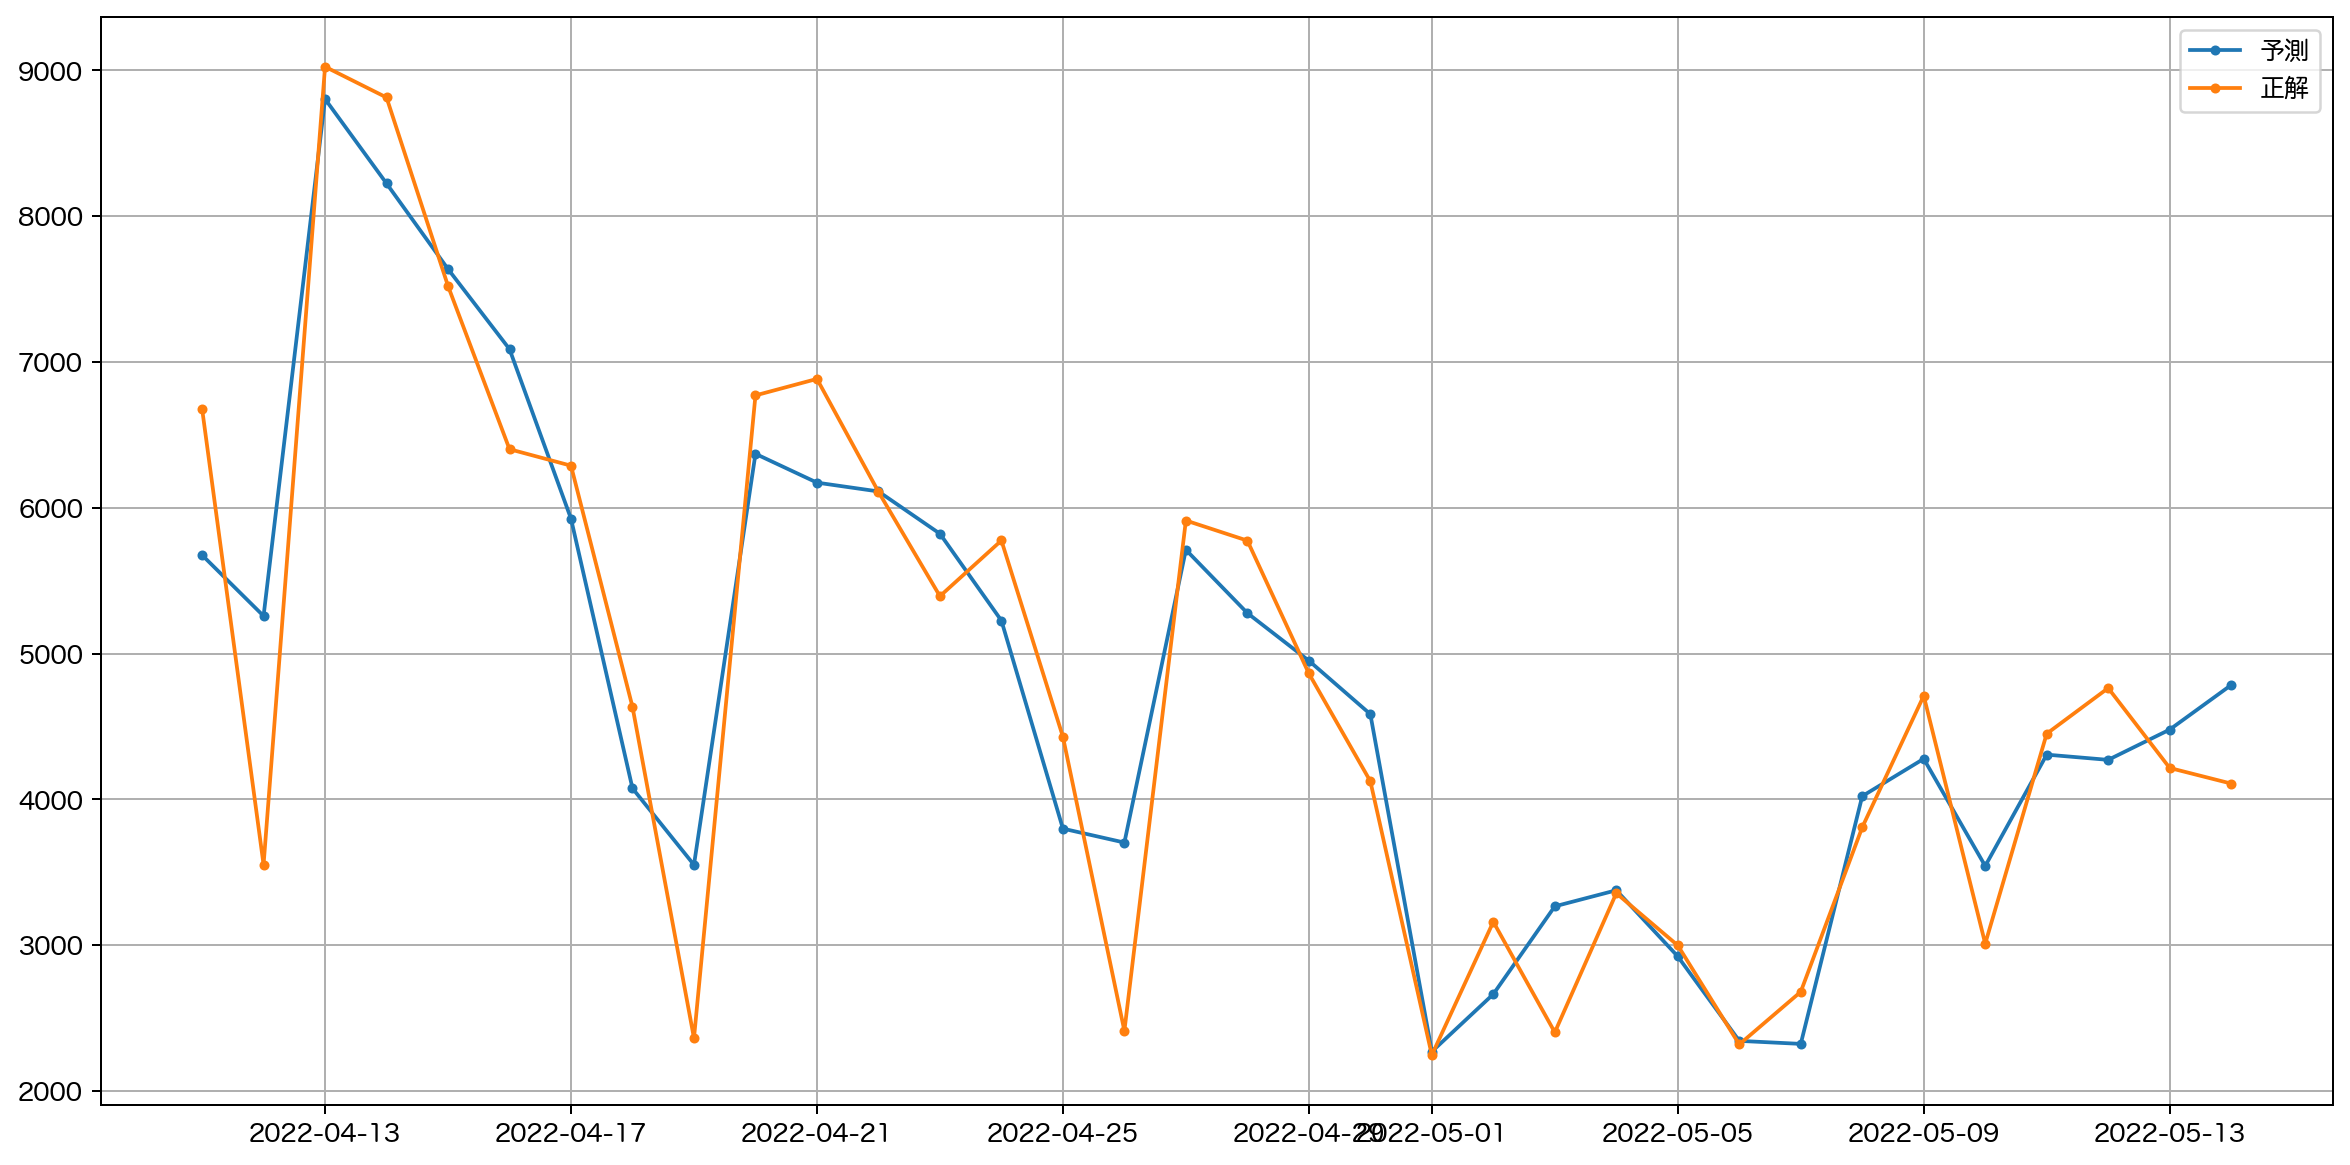

In [11]:
# テスト
fig = plt.figure(figsize=(16, 8), dpi=180)
ax = fig.add_subplot(111)
x = df.index[test_start+(N+w-1):]
ax.plot(x, Yts_pred_inv_log_inv, label="予測", marker=".")
ax.plot(x, Yts_org, label="正解", marker=".")
ax.legend()
plt.grid(True)
plt.show()

In [12]:
import datetime
# 明日の予測

Xts_new = Xts[-w:].reshape(-1, 1)# 今日からw日前分の対数差分
Yts_org_new = df.iloc[-1]["Tokyo"] # 今日の感染者数

Xts_new_norm = scalerX.transform(Xts_new) # 標準化

Xts_new_trs = Xts_new_norm.reshape(1, -1) # 窓処理

Yts_new_pred = model.predict(Xts_new_trs) # 予測
# 標準化戻す
Yts_new_pred_inv = scalerY.inverse_transform(Yts_new_pred).reshape(-1, ) # 予測
Yts_new_pred_inv_log_inv = np.expm1(Yts_new_pred_inv + np.log1p(Yts_org_new)) # expm1(予測値+log1p(前日の値))が予測値になる

p = np.round(Yts_new_pred_inv_log_inv[-1])
print("東京都の{}の予測陽性者数：{}".format((df.index[-1] + datetime.timedelta(days=1)).strftime('%Y-%m-%d'), p))

東京都の2022-05-15の予測陽性者数：4103.0


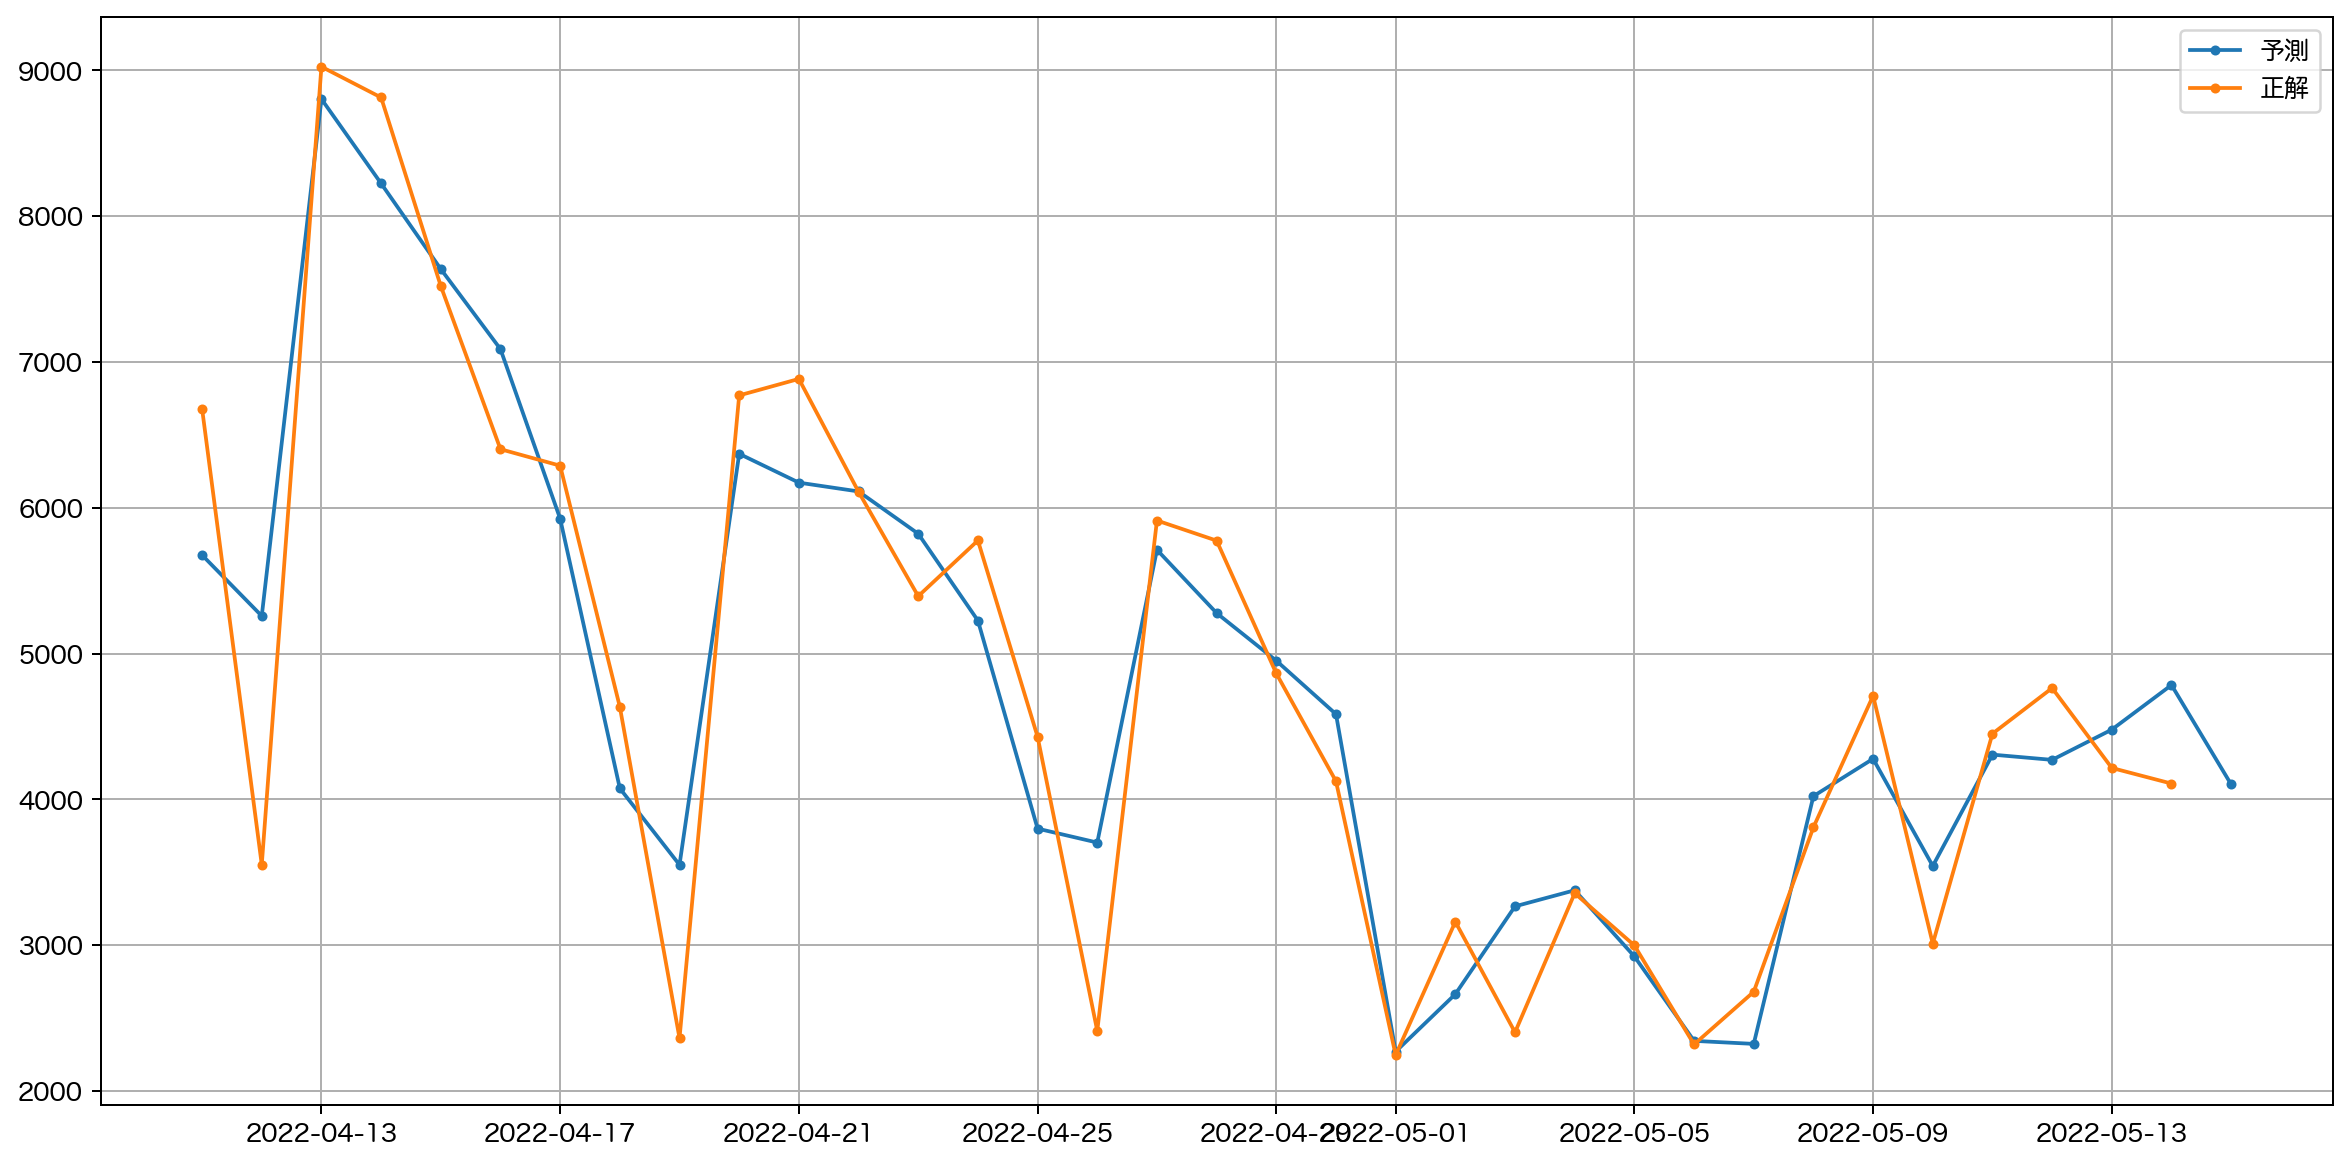

In [13]:
# 最新の予測つき
fig = plt.figure(figsize=(16, 8), dpi=180)
ax = fig.add_subplot(111)
x = pd.date_range(start="2022-04-11", periods=len(x)+1, freq="D")
ax.plot(x, np.append(Yts_pred_inv_log_inv, p), label="予測", marker=".")
ax.plot(x, np.append(Yts_org, np.nan), label="正解", marker=".")
ax.legend()
plt.grid(True)
plt.show()